# Exploratory Analysis on one year of TSLA Reddit posts and TSLA stock prices from July 2021 through July 2022

In [90]:
import pandas as pd
import numpy as np

In [91]:
reddit_df = pd.read_csv('cleaned_reddit_posts_fixed.csv')
price_df = pd.read_csv('cleaned_TSLA_stock_data.csv')

In [92]:
reddit_df.head()

,created_utc,cleaned_text
0,2022-07-04 23:33:29,tsla net profit across trades accuracy profit ...
1,2022-07-04 22:57:52,tsla incoming
2,2022-07-04 22:38:37,tsla week
3,2022-07-04 21:55:08,gary black twitter tsla delivered k units june...
4,2022-07-04 18:44:27,tesla tsla missed q deliveries estimates


In [93]:
price_df.head()

,Date,Adj Close,Close,High,Low,Open,Volume
0,2021-07-06,219.860001,219.860001,228.000000,217.133331,227.236664,69853500
1,2021-07-07,214.883331,214.883331,221.899994,212.773331,221.423340,56376000
2,2021-07-08,217.603333,217.603333,218.143326,206.820007,209.456665,68319900
3,2021-07-09,218.983337,218.983337,219.636673,214.896667,217.726669,54421500
4,2021-07-12,228.566666,228.566666,229.080002,220.720001,220.733337,77781000


In [94]:
print(reddit_df.dtypes)
print(price_df.dtypes)

created_utc     object
cleaned_text    object
dtype: object
Date          object
Adj Close    float64
Close        float64
High         float64
Low          float64
Open         float64
Volume         int64
dtype: object


In [95]:
reddit_df['created_utc'] = pd.to_datetime(reddit_df['created_utc'])
start_date = reddit_df['created_utc'].min()
end_date = reddit_df['created_utc'].max()

print(f"Date range: {start_date} to {end_date}")



The date range is from 2021-07-05 00:56:35 to 2022-07-04 23:33:29


In [96]:
price_df['Date'] = pd.to_datetime(price_df['Date'])
start_date = price_df['Date'].min()
end_date = price_df['Date'].max()

print(f"Date range: {start_date} to {end_date}")

The date range is from 2021-07-06 00:00:00 to 2022-07-01 00:00:00


## Exploring the number of Tesla stock-related Reddit posts from July 2021 - July 2022

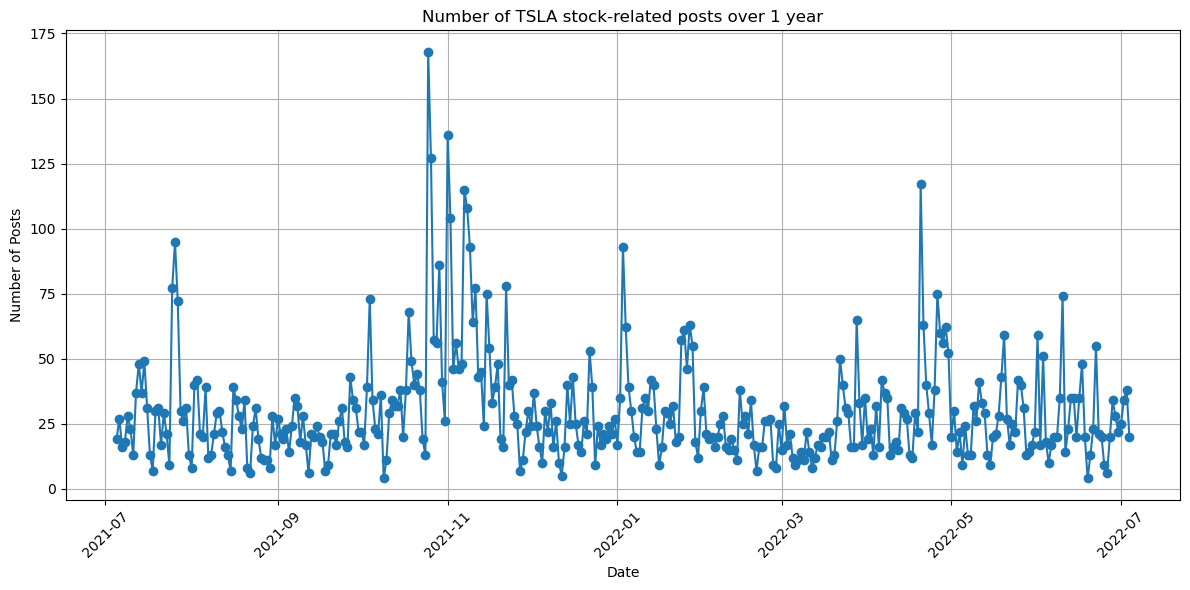

In [97]:
reddit_df['date'] = reddit_df['created_utc'].dt.date
daily_posts = reddit_df.groupby('date').size()
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
daily_posts.plot(kind='line', title='Number of TSLA stock-related posts over 1 year', marker='o')

plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()



## Sentiment Analysiss EDA

In [98]:
#ensure no null values in the cleaned text
reddit_df['cleaned_text'] = reddit_df['cleaned_text'].fillna('').astype(str)

In [99]:
#creating a word count col containing total words per post
reddit_df['word_count'] = reddit_df['cleaned_text'].str.split().apply(len)
print(reddit_df[['cleaned_text', 'word_count']].head())

                                        cleaned_text  word_count
0  tsla net profit across trades accuracy profit ...          16
1                                      tsla incoming           2
2                                          tsla week           2
3  gary black twitter tsla delivered k units june...          35
4           tesla tsla missed q deliveries estimates           6


In [100]:
#determine most common words across TSLA Reddit posts
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english', max_features=10)
word_counts = vectorizer.fit_transform(reddit_df['cleaned_text'])
print("Most common words:", vectorizer.get_feature_names_out())

Most common words: ['buy' 'daily' 'earnings' 'market' 'price' 'removed' 'stock' 'tesla'
 'thread' 'tsla']


## Using Vader sentiment model to produce sentiment data on Reddit posts

The Vader model is a simplistic sentiment model that is appropriate for social media text analysis -- hence why we are using it to conduct EDA on the gathered Reddit data. It is a quick model which allows us to gain some quick insights on the text 

In [101]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
reddit_df['sentiment'] = reddit_df['cleaned_text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

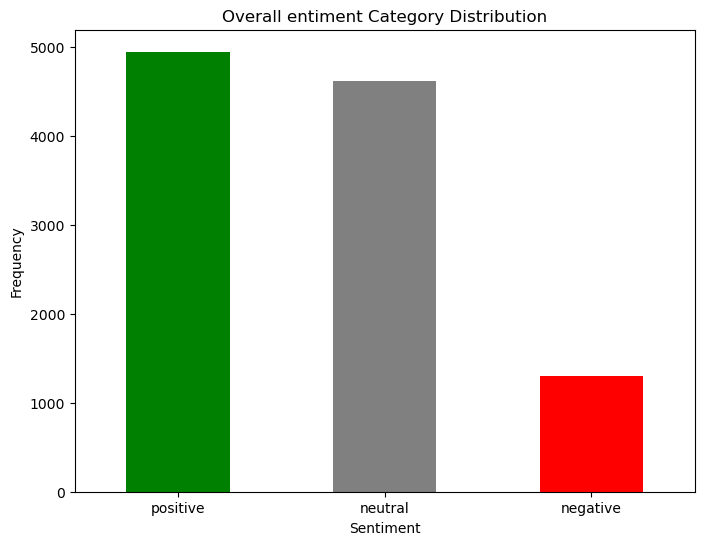

In [102]:
#create sentiment buckets
reddit_df['sentiment_category'] = reddit_df['sentiment'].apply(
    lambda x: 'positive' if x > 0.05 else ('negative' if x < -0.05 else 'neutral')
)

sentiment_counts = reddit_df['sentiment_category'].value_counts()

plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['green', 'gray', 'red'])
plt.title('Overall entiment Category Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()


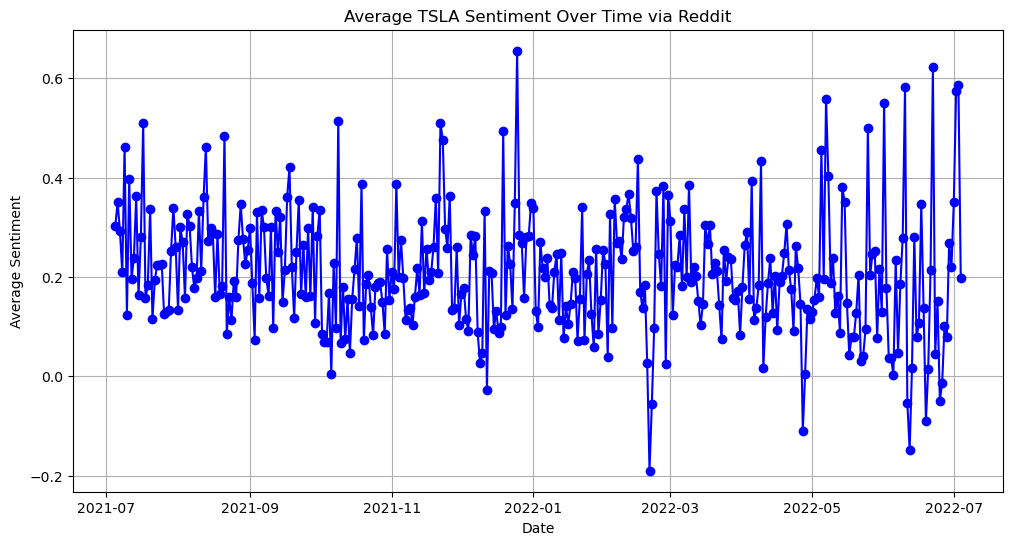

In [103]:
#avg sentiment per day
daily_sentiment = reddit_df.groupby(reddit_df['created_utc'].dt.date)['sentiment'].mean()

#plotting avg sentiment over time
plt.figure(figsize=(12, 6))
daily_sentiment.plot(kind='line', marker='o', color='blue', title='Average TSLA Sentiment Over Time via Reddit')
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.grid(True)
plt.show()


## TSLA Price Data EDA

<Axes: title={'center': 'TSLA Stock Price Over 1 Yr'}, xlabel='Date'>

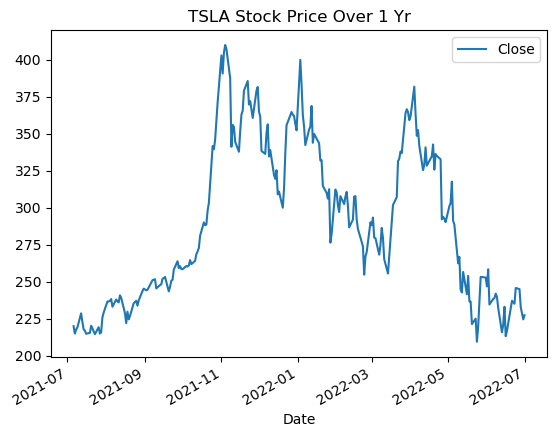

In [104]:
price_df['Date'] = pd.to_datetime(price_df['Date'])
price_df.plot(x='Date', y='Close', title='TSLA Stock Price Over 1 Yr')

## Merging Price Data and Reddit Data for later analysis

In [105]:
#reddit date col already created
price_df['date'] = price_df['Date'].dt.date
merged_df = pd.merge(reddit_df, price_df, on='date', how='inner')

In [106]:
daily_sentiment = merged_df.groupby('date')['sentiment'].mean()

In [108]:
daily_sentiment.head()

date
2021-07-06    0.350693
2021-07-07    0.292131
2021-07-08    0.208911
2021-07-09    0.462443
2021-07-12    0.196095
Name: sentiment, dtype: float64

## Exploring Correlation between closing prices and Reddit sentiment

In [109]:
#calculating price change from opening and closing prices
price_df['price_change'] = price_df['Close'] - price_df['Open']


In [110]:
#merging sentiment data and price change data to find correlation
sentiment_price_merged_df = pd.merge(daily_sentiment, price_df, left_index=True, right_on='date')

correlation = sentiment_price_merged_df[['sentiment', 'price_change']].corr()
print("Correlation between sentiment and price change:\n", correlation)

Correlation between sentiment and price change:
               sentiment  price_change
sentiment      1.000000      0.032246
price_change   0.032246      1.000000


In [113]:
#trying lagged sentiment correlation
sentiment_price_merged_df['lagged_sentiment'] = sentiment_price_merged_df['sentiment'].shift(1)
lagged_correlation = sentiment_price_merged_df[['lagged_sentiment', 'price_change']].corr()
print("Lagged Correlation:\n", lagged_correlation)

Lagged Correlation:
                   lagged_sentiment  price_change
lagged_sentiment           1.00000       0.13082
price_change               0.13082       1.00000


Here, we try to use a lagged sentiment to see if the correlation improves

In [114]:
#trying additional lagged sentiment correlation
sentiment_price_merged_df['lagged_sentiment_2'] = sentiment_price_merged_df['sentiment'].shift(2)
sentiment_price_merged_df['lagged_sentiment_3'] = sentiment_price_merged_df['sentiment'].shift(3)
lagged_correlation = sentiment_price_merged_df[['lagged_sentiment', 'lagged_sentiment_2', 'lagged_sentiment_3', 'price_change']].corr()
print(lagged_correlation)


                    lagged_sentiment  lagged_sentiment_2  lagged_sentiment_3  \
lagged_sentiment            1.000000            0.084417            0.176198   
lagged_sentiment_2          0.084417            1.000000            0.084206   
lagged_sentiment_3          0.176198            0.084206            1.000000   
price_change                0.130820           -0.087901           -0.027176   

                    price_change  
lagged_sentiment        0.130820  
lagged_sentiment_2     -0.087901  
lagged_sentiment_3     -0.027176  
price_change            1.000000  


Correlation decreases with increased lag sentimentent

## Plotting Sentiment Data against Closing Price

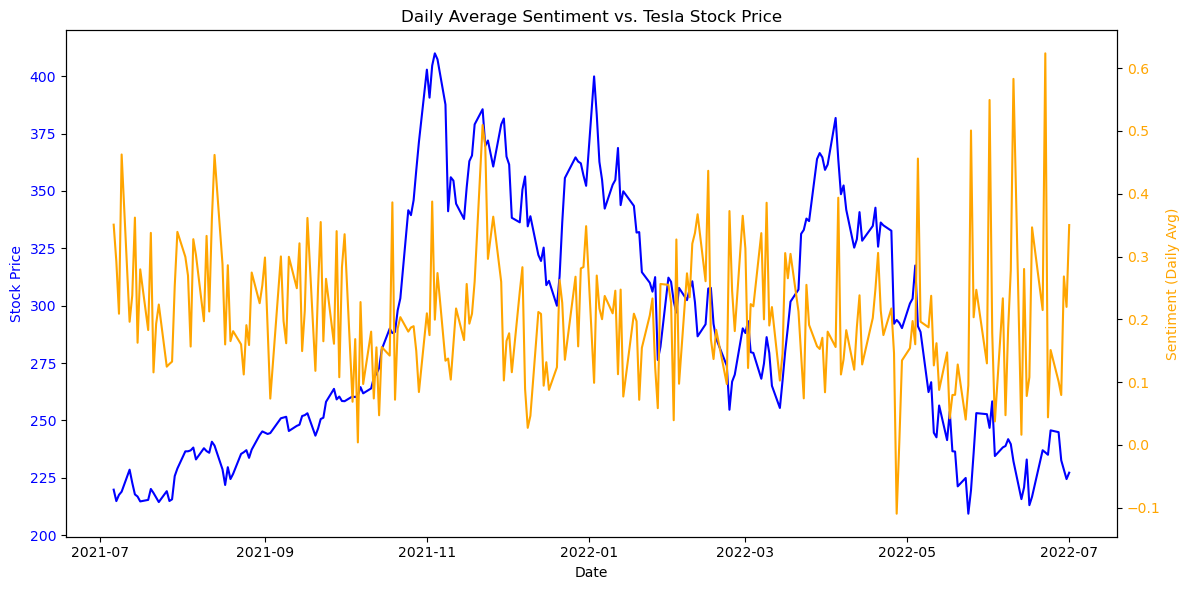

In [117]:
#aggregating sentiment to daily avgs for easier readability
daily_sentiment = merged_df.groupby('date')['sentiment'].mean()

daily_stock_price = merged_df.groupby('date')['Close'].mean()

fig, ax1 = plt.subplots(figsize=(12, 6))

#plotting stock price
ax1.plot(daily_stock_price.index, daily_stock_price, label='Stock Price', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

#plotting aggregated sentiment
ax2 = ax1.twinx()
ax2.plot(daily_sentiment.index, daily_sentiment, label='Sentiment', color='orange')
ax2.set_ylabel('Sentiment (Daily Avg)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('Daily Avg Sentiment vs. TSLA Price')
fig.tight_layout()
plt.show()
